In [1]:
from neo4j import GraphDatabase, basic_auth, Driver
import os
from dotenv import load_dotenv
import pandas as pd
from scipy.stats import pearsonr
import networkx as nx
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
load_dotenv()
DB_HOST = os.getenv("NEO4J_HOST")
DB_PORT = os.getenv("NEO4J_PORT")
DB_USER = os.getenv("NEO4J_USER")
DB_PASS = os.getenv("NEO4J_PASS")

In [3]:
driver = GraphDatabase.driver(f"bolt://{DB_HOST}:{DB_PORT}", auth=basic_auth(DB_USER, DB_PASS))
driver

In [4]:
with driver.session() as session:
    query = """
        MATCH (n:Artist {in_last_fm: true})-[:COLLAB_WITH]->()
        WITH DISTINCT(n)
        RETURN n.main_id AS main_id, n.popularity_scaled as popularity_scaled
    """
    q_result = session.run(query)
    df = pd.DataFrame(q_result.data())

df.sort_values(by="popularity_scaled", inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Found {len(df)} artists")

Found 512749 artists


In [5]:
G = nx.Graph()
# Nodes
with driver.session() as session:
    query = "MATCH (n:Artist {in_last_fm:true}) RETURN n.main_id as main_id;"
    records = session.run(query)
    for artist in records:
        G.add_node(artist["main_id"])
# Edges
with driver.session() as session:
    query = """
        MATCH (a:Artist {in_last_fm: true})-[r:COLLAB_WITH]->(b:Artist {in_last_fm: true})
        WHERE a < b
        RETURN a.main_id as a, b.main_id as b, r.count as weight;
    """
    records = session.run(query)
    for rel in records:
        a, b, w = rel["a"], rel["b"], rel["weight"]
        G.add_edge(a, b, weight=float(w))

In [6]:
df_len = len(df)
params = list()
x_axis = np.arange(0.0, 100.0, 0.5)
for start_p in x_axis:
    print("Computing for", start_p)

    start_i = int(start_p / 100.0 * df_len)
    subdf = df.loc[start_i:df_len].copy()
    subdf = subdf.reset_index()

    subg = G.subgraph(subdf.main_id)

    params.append([start_p, subdf, subg])

Computing for 0.0
Computing for 0.5
Computing for 1.0
Computing for 1.5
Computing for 2.0
Computing for 2.5
Computing for 3.0
Computing for 3.5
Computing for 4.0
Computing for 4.5
Computing for 5.0
Computing for 5.5
Computing for 6.0
Computing for 6.5
Computing for 7.0
Computing for 7.5
Computing for 8.0
Computing for 8.5
Computing for 9.0
Computing for 9.5
Computing for 10.0
Computing for 10.5
Computing for 11.0
Computing for 11.5
Computing for 12.0
Computing for 12.5
Computing for 13.0
Computing for 13.5
Computing for 14.0
Computing for 14.5
Computing for 15.0
Computing for 15.5
Computing for 16.0
Computing for 16.5
Computing for 17.0
Computing for 17.5
Computing for 18.0
Computing for 18.5
Computing for 19.0
Computing for 19.5
Computing for 20.0
Computing for 20.5
Computing for 21.0
Computing for 21.5
Computing for 22.0
Computing for 22.5
Computing for 23.0
Computing for 23.5
Computing for 24.0
Computing for 24.5
Computing for 25.0
Computing for 25.5
Computing for 26.0
Computing for

In [7]:
def apply_custom_cumsum(df: pd.DataFrame) -> None:
    i = 0
    current_cum_sum = 0
    while i < len(df) - 1:
        if df.loc[i, "pagerank"] != df.loc[i + 1, "pagerank"]:
            current_cum_sum += df.loc[i, "pagerank"]
            df.loc[i, "pagerank_acc"] = current_cum_sum
            i += 1
        else:
            j = i + 1
            current_cum_sum += df.loc[i, "pagerank"]
            while df.loc[j, "pagerank"] == df.loc[i, "pagerank"] and  j < len(df) - 1:
                current_cum_sum += df.loc[j, "pagerank"]
                j += 1
            for k in range(i, j):
                df.loc[k, "pagerank_acc"] = current_cum_sum
            i = j
    df.loc[i, "pagerank_acc"] = current_cum_sum + df.loc[i, "pagerank"]

def task(p:float, df: pd.DataFrame, G: nx.Graph) -> tuple[float, float, float]:
    print("Started task for", p)
    print("DF length:", len(df))

    pg = nx.pagerank(G)
    df["pagerank"] = df["main_id"].map(pg)
    df["pagerank_cumsum"] = df['pagerank'].cumsum()
    df["pagerank_acc"] = df['pagerank_cumsum']  # Need a placeholder
    apply_custom_cumsum(df)

    pop_pg, p_pop_pg = pearsonr(df["popularity_scaled"], df["pagerank"])
    if p_pop_pg >= 0.05:
        print("Found conflicting p-value for PageRank:", p_pop_pg)

    pop_pg_cs, p_pop_pg_cs = pearsonr(df["popularity_scaled"], df["pagerank_cumsum"])
    if p_pop_pg_cs >= 0.05:
        print("Found conflicting p-value for PageRank_CumSum:", p_pop_pg)

    pop_pg_acc, p_pop_pg_acc = pearsonr(df["popularity_scaled"], df["pagerank_acc"])
    if p_pop_pg_acc >= 0.05:
        print("Found conflicting p-value for PageRankAcc:", p_pop_pg)

    print("Ended task for", p)

    return pop_pg, pop_pg_cs, pop_pg_acc

In [8]:
num_workers = 5
with mp.Pool(num_workers) as pool:
    results = pool.starmap(task, params)

Started task for 0.0
DF length: 512749
Started task for 5.0
DF length: 487112
Started task for 10.0
DF length: 461475
Started task for 15.0
DF length: 435837
Started task for 20.0
DF length: 410200
Ended task for 5.0
Started task for 5.5
DF length: 484548
Ended task for 0.0
Started task for 0.5
DF length: 510186
Ended task for 15.0
Started task for 15.5
DF length: 433273
Ended task for 10.0
Started task for 10.5
DF length: 458911
Ended task for 20.0
Started task for 20.5
DF length: 407636
Ended task for 15.5
Started task for 16.0
DF length: 430710
Ended task for 20.5
Started task for 21.0
DF length: 405072
Ended task for 5.5
Started task for 6.0
DF length: 481985
Ended task for 10.5
Started task for 11.0
DF length: 456347
Ended task for 0.5
Started task for 1.0
DF length: 507622
Ended task for 21.0
Started task for 21.5
DF length: 402508
Ended task for 16.0
Started task for 16.5
DF length: 428146
Ended task for 11.0
Started task for 11.5
DF length: 453783
Ended task for 6.0
Started tas

In [9]:
normal = [result[0] for result in results]
cumsum = [result[1] for result in results]
acc = [result[2] for result in results]

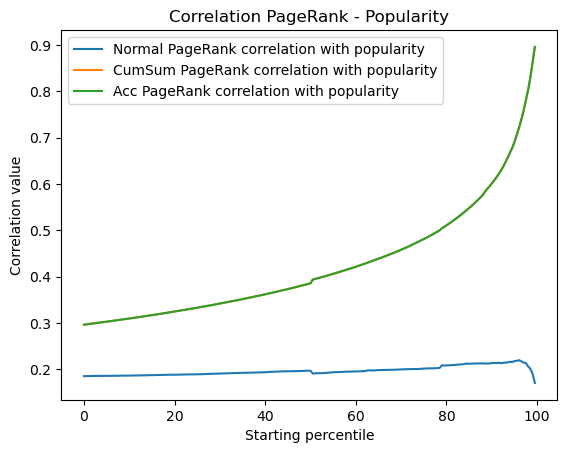

In [12]:
plt.plot(x_axis, normal, label="Normal PageRank correlation with popularity")
plt.plot(x_axis, cumsum, label="CumSum PageRank correlation with popularity")
plt.plot(x_axis, acc, label="Acc PageRank correlation with popularity")

plt.title("Correlation PageRank - Popularity")
plt.xlabel("Starting percentile")
plt.ylabel("Correlation value")
plt.legend()

plt.show()